# Step4 演習02 教師なし学習
---

本演習では、スパースオートエンコーダーと呼ばれるものを実装し、畳み込みのフィルターを教師なしで学習します。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での利用は避けてください。

**本演習の目的**
- オートエンコーダーの理解
- スパース正則化の実装

## 自己符号化器（オートエンコーダ）とは？

講義では自己符号化器（オートエンコーダ）について説明していなかったのでここで説明したいと思います。

オートエンコーダ自体はただ全結合層をスタックしたものです。クラス分類問題は入力$\boldsymbol{x}$があり、それから出力$\boldsymbol{y}$を予測しました。しかしオートエンコーダの場合は出力は入力と同じ、$\boldsymbol{y}=\boldsymbol{x}$とします。よってオートエンコーダではニューラルネットワークを使って出力ができる限り入力に近くなるように確率的勾配降下法で学習します。一番基本的なオートエンコーダは2層の全結合層から構成されており、一層目の重み、バイアス、活性化関数を$\boldsymbol{w}^{(1)}, \boldsymbol{b}^{(1)}, \boldsymbol{f}^{(1)}$とすると出力$\boldsymbol{y}$は、

\begin{eqnarray}
\boldsymbol{y}=f^{(1)}(\boldsymbol{w}^{(1)}\boldsymbol{x} + \boldsymbol{b}^{(1)})
\end{eqnarray}

と表せます。次に二層目の重み、バイアス、活性化関数を$\boldsymbol{w}^{(2)}, \boldsymbol{b}^{(2)}, \boldsymbol{f}^{(2)}$とすると出力$\hat{\boldsymbol{x}}$は、
\begin{eqnarray}
\hat{\boldsymbol{x}}=f^{(2)}(\boldsymbol{w}^{(2)}\boldsymbol{y} + \boldsymbol{b}^{(2)})
\end{eqnarray}
となります。これを図にすると下図ようになります。
<br>
<br>

<div style="width:40%">
<img src="./img/step4_autoencoder.png" height="200"></div>

オートエンコーダは通常中間層のユニット数はは入力層よりも少なくなっています。つまりオートエンコーダは入力情報を一旦圧縮し、その後圧縮した情報を復元します。ここで中間層の出力を$\boldsymbol{x}$の符号(code)と見なし、入力層から中間層への変換を符号化（encode）中間層から出力層への変換を（decode）と呼びます。

この演習では[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)の画像から8×8の小さなパッチを取り出し、そのパッチを再現するオートエンコーダを作成します。この演習の大まかな流れを図にするとこのようになります。

<div style="width:40%">
<img src="./img/step4_autoencoder2.png" height="200"></div>

まず、入力パッチをベクトル化したものを$\boldsymbol{x}$とします。そしてオートエンコーダへの入力はこの$\boldsymbol{x}$に対してZCA白色化（詳しくは後ほど）したものとします。そして出力$\hat{\boldsymbol{x}}$とZCA白色化していない$\boldsymbol{x}$が近くなるように最適化します。

## ライブラリのインストール

まずはじめに、本演習で利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント

`%matplotlib inline` はnotebook上で使える[magic function](http://ipython.readthedocs.io/en/stable/interactive/magics.html)の一つで、これによりmatplotlibをインタラクティブに使うことできます。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# 以下はデータの読み込みに使用
import pickle
import os

## データの読み込み

この演習では[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)と呼ばれる32×32ピクセルのRGB画像を含んだデータセットを用います。画像は10クラスに分かれており、各クラス6,000枚あります。そのうち5,000枚が訓練用で、1,000枚がテスト用です。訓練データは6つのファイルに分割されていますが、今回は1つ目のファイルのみを読み込み、更にそのうちの初めの1000のみを演習として使用します。

In [2]:
def load_cifar10(path, num_training):
    batch = 1
    file = os.path.join(path, "data_batch_{0}".format(batch))
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='iso-8859-1')
    X = data["data"].reshape(10000, 3, 32, 32).astype("float64")
    X = X.transpose(0,2,3,1)
    y = np.array(data["labels"])

    X_train, y_train = X[:num_training], y[:num_training]
    X_train /= 255.
    return (X_train, y_train)

In [3]:
X_train, y_train  = load_cifar10('./dataset/cifar-10-batches-py', 1000)

訓練データのshapeを確認してます。

In [4]:
print("訓練データ: {}".format(X_train.shape))

訓練データ: (1000, 32, 32, 3)


In [5]:
class_name = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer',
              5: 'dog', 6: 'frog', 7: 'hourse', 8: 'ship', 9: 'truck'}

次に訓練データの画像をランダムに表示させてみます。セルを実行するたびに画像が変わります。32ピクセル×32ピクセルと非常に小さいのでぼやけたような画像になります。

Class: truck


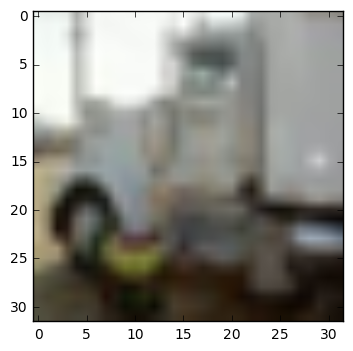

In [6]:
num = np.random.randint(0, len(X_train))
plt.imshow(X_train[num])
print('Class: {}'.format(class_name[y_train[num]]))

## パッチの作成

`get_patch`は訓練データからランダムに8×8のパッチを50,000枚取り出すプログラムで、2つの引数があります。
- `X`: 入力画像、（バッチ、縦、横、チャンネル）
- `num`: 作成するパッチの枚数（ここでは5万枚をデフォルトとします。）

ここでは出力のパッチ数分forループさせ、その都度入力Xからランダムに1枚画像を選び、その画像中の領域をランダムにクロップします。

In [7]:
def get_patch(X, num=50000):
    # まず出力であるパッチをゼロで初期化
    patch = np.zeros((num, 8, 8, 3))
    for num, i in enumerate(patch):
        np.random.seed(num)
        x = X[np.random.randint(0, len(X)-1)]
        h_start = np.random.randint(0, 23)
        h_end = h_start + 8
        w_start = np.random.randint(0, 23)
        w_end = w_start + 8
        i += x[h_start:h_end, w_start:w_end, :]
    return patch

In [8]:
patches = get_patch(X_train)

In [9]:
print("パッチ: {}".format(patches.shape))

パッチ: (50000, 8, 8, 3)


ここでパッチ画像をランダムに表示させてみます。セルを実行するたびに画像が変わります。

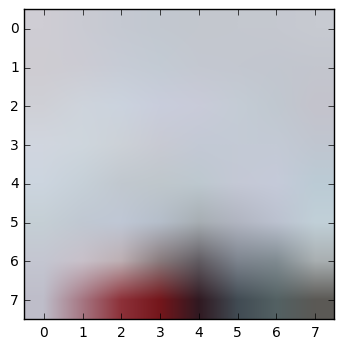

In [10]:
plt.imshow(patches[np.random.randint(0, len(patches)-1)])

### ZCA白色化

ここでは、先程作成したパッチに対してZCA白色化（zero-phase component analysis, ZCA)します。平均0で、共分散行列Mを持つベクトル化した入力X（D次元）に対し、$WW^\top=M^{-1}$を満たす行列W(D×D次元）を用いて線形変換$Y=WX$をすることにより白色化された$Y$が得られます。しかし条件を満たす$W$は無数にあるので、ここでは$W=M^{-1/2}$となる、言い方を変えれば$W$が対称行列になるように制約を加えます。このような制約を加えた白色化をZCA白色化と呼びます。

In [11]:
class ZCA_Whitening:
    def __init__(self, epsilon=1e-6):
        self.epsilon = epsilon
        
    def fit(self, x):
        # 入力Xから平均を引く
        self.mean = np.mean(x, axis=0)
        x -= self.mean
        # 共分散行列を求める。
        cov_mat = np.dot(x.T, x) / x.shape[0]
        # SVDを用いて対称行列Wを求める
        u, s, v = np.linalg.svd(cov_mat)
        self.W = np.dot(u, np.dot(np.diag(1. / (np.sqrt(s) + self.epsilon)), u.T))
            
    def transform(self, x):
        x -= self.mean
        x = np.dot(x, self.W)
        return x

In [12]:
# まず入力であるpatchesをベクトル化
m = patches.shape[0]
X = patches.reshape(m, -1)
# ZCA白色化は入力のみに適用するのでまずオートエンコーダの出力用にコピーを取る
X_hat = np.copy(X)
# 対称行列Wの計算
zca = ZCA_Whitening()
zca.fit(X)
# 実際に入力Xを白色化
X = zca.transform(X)

In [13]:
print(X.shape)

(50000, 192)


## FC層の実装

**【課題１】** Step4演習1と同様の重みを正規分布に従って初期化する関数を作成します。

In [14]:
#Coursedele-02 Step4 QuestionNumber7 7a2e2aa885368ba057666dc0c4614903
def init_gaussian(shape, std=0.001):
    np.random.seed(1234)
    ###############START CODE HERE###############
    out = np.random.normal(scale=std, size=shape)
    ################END CODE HERE################
    return out

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [15]:
%%bash
./validation_client.py dele-02 4 7 Step4_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



**【課題２】** 全結合層をFC()を実装してください。

今回は全結合層を用いたオートエンコーダを実装するので、Step4 演習1と同じ全結合層`FC`を用意します。ただし、今回はL2正則化を行うのでL2正則化のパラメータ用に`FC`内の`def __init__()`の引数として`lam2`があります。

In [16]:
#Coursedele-02 Step4 QuestionNumber8 9d5dccb9fa0ff1dd97180ba728c7e977
class FC():
    def __init__(self, in_size, out_size, lam2=0.0):
        ###############START CODE HERE###############
        '''
        Wの形は(in_size, out_size)
        bの形は（1, out_size)
        '''
        self.W = init_gaussian((in_size,out_size))
        self.b = np.zeros((1,out_size))
        ################END CODE HERE################
        self.params = [self.W, self.b]

    def forward(self, X):
        self.X = X # backwardで使うためself.Xと置く
        ###############START CODE HERE###############
        out = np.dot(self.X,self.W) + self.b
        ################END CODE HERE################
        return out

    def backward(self, dX):
        ###############START CODE HERE###############
        dW = np.dot(self.X.T, dX)
        db = np.sum(dX,axis=0)
        dX_prev = np.dot(dX, self.W.T)
        ################END CODE HERE################
        return dX_prev, [dW, db]

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [17]:
%%bash
./validation_client.py dele-02 4 8 Step4_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## ReLUのスパース正則化の実装

**【課題３】**ここでは、活性化関数の1つである、`class　ReLU()`を実装します。このクラスの形式ははじめに実装した全結合層`FC`と形式を合わせています。

ReLUはある入力テンソル$\boldsymbol{x}$を受け取り、これに対し、

$max(0,\boldsymbol{x})$

を計算をします。ReLUの勾配計算では入力が0以上だった箇所のみ勾配を伝播させ、0より小さい箇所の勾配を0にするだけです。

ただ、これで終わりではなくここの本題はスパース正則化の実装です。オートエンコーダでは中間層のユニット数を制約し、入力画像を復元するのに必要な特徴を見つけようとします。ただし、オートエンコーダに何も制約を加えないと、復元することだけが目標なのであまりよい特徴（必要最低限の情報を持つ特徴）は学習できません。そこでここではユニットの層の平均活性度$\hat{\rho_j}$が小さくなるような制約を加えます。ある層のユニット\{a_j\}の平均活性度は、
\begin{eqnarray}
\hat{\rho_j} = \frac{1}{m}\sum_{i=1}^m\{a_j\}
\end{eqnarray}
で計算できます。ここで$m$はバッチ数です。スパース正則化ではこの平均活性度$\hat{\rho_j}$を平均活性度の目標値$\rho$に近くなるような制約を加えます。よって、ニューラルネットワークのコスト関数に以下の項を付け加えます。
\begin{eqnarray}
\beta\sum_{j=1}^{\# of units}\{\rho log\frac{\rho}{\hat{\rho_j}} + (1-\rho) log\frac{1-\rho}{1-\hat{\rho_j}}\}=\beta\sum_{j=1}^{\# of units}KL(\rho||\hat{\rho_j})
\end{eqnarray}
$\beta$は他のコスト関数とのバランスを取るために設定するパラメータです。この式をプロットすると、このようになります。この式の総和の中は平均$\hat{\rho_j}$と$\rho$の2つのベルヌーイ分布間のカルバック・ライブラー・ダイバージェンス（Kullback-Leibler Divergence, KL Divergence)を表しています。この式の特徴は0から1の間では平均活性度の時に最小値を取ることです。

<img src="./img/step4_KL.png" height="200">

長くなったので少し整理します。この演習では、

**def forward(self, X):**

このメソッドではまずReLUの順伝播を計算します。[np.maximum](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.maximum.html)を使うことで1行で書けます。次に、上式の$\beta$が0でないときは平均活性度${\hat{\rho_j}}$を計算します。その後分母に0にならないように処理を施します。

**def backward(self, dX):**

まず、$\beta$が0ではないときは上式を微分したものを`dout`に足します。微分は自分で計算してみて下さい。次にReLUの勾配計算を記述して下さい。ReLUでは順伝播時に0以上だった箇所のみ勾配を伝播し、0より小さい場合は勾配は0にします。

**def sparse_regularization(layers):**

ここでKLダイバージェンスを計算しますが、`ReLU`とは別に記述します。ここは上式をそのままpythonコードに書き直すだけです。

In [18]:
#Coursedele-02 Step4 QuestionNumber9 ec1c462d5c5291c9e9a33f789607c521
class ReLU():
    def __init__(self, rho=0.0, beta=0.0):
        self.params = []
        self.rho = rho
        self.beta = beta
        self.rho_hat = 0.0
        self.rho_hat_prev = 0.0

    def forward(self, X):
        self.X = X
        ###############START CODE HERE###############
        # max(0,x)の計算
        out = np.maximum(0,self.X)
        # パラメータβが0出ないときはスパース正則化に使う平均活性度
        if self.beta != 0:
            # 平均活性度の算出
            self.rho_hat = np.mean(X, keepdims=True)
            # 分母が0にならないよう予め処理しておく
            self.rho_hat = np.maximum(self.rho_hat, 1e-6)
        ###############END CODE HERE###############
        return out

    def backward(self, dout):
        rho_hat = self.rho_hat
        rho = self.rho
        beta = self.beta
        ###############START CODE HERE###############
        # パラメータβが0でないときはスパース正則化の勾配をdoutに足す
        if beta != 0:
            dout += beta * (-(rho/rho_hat) + ((1-rho)/(1-rho_hat)))
        dX = dout
        # ReLUの勾配計算、1行
        dX[self.X <= 0] = 0
        ################END CODE HERE################
        return dX, []

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [19]:
%%bash
./validation_client.py dele-02 4 9 Step4_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



**【課題４】** sparse_regularization()を実装してください。

In [20]:
#Coursedele-02 Step4 QuestionNumber10 0f67f53f72529dcb5ef545c378c0976c
def sparse_regularization(layers):
    cost = 0.0
    for layer in layers:
        if hasattr(layer, 'rho_hat'):# layerにrho_hatという属性（attribute）がある場合
            rho_hat = layer.rho_hat
            rho = layer.rho
            beta = layer.beta
            if beta != 0.0:
                ###############START CODE HERE###############
                cost += beta * (-(rho/rho_hat) + ((1-rho)/(1-rho_hat)))
                ################END CODE HERE################
    return cost

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [21]:
%%bash
./validation_client.py dele-02 4 10 Step4_02.ipynb api.internal.zero2one.jp

ExcessiveAccess: Wait for 10 minutes



## L2正則化の実装

ここでは、L2正則化も実装します。L2正則化により重みそのものの値が小さくするように制約されます。式では、
\begin{eqnarray}
L_2 = \frac{1}{2}\lambda W^2
\end{eqnarray}
のようになります。ここで$\lambda$はスパース正則化同様にパラメータです。勾配は$W$について微分するだけなので簡単に求められます。

In [22]:
def l2_regularization(layers):
    cost = 0.0
    for layer in layers:
        if hasattr(layer, 'lam2'):# layerにlam2という属性（attribute）がある場合
            lam2 =  layer.lam2
            cost += 0.5 * lam2 * np.sum(layer.W * layer.W)
    return cost


def delta_l2_regularization(layers, grads):
    for layer, grad in zip(layers, reversed(grads)):
        if hasattr(layer, 'lam2'):
            lam2 =  layer.lam2
            grad[0] += lam2 * layer.W # 勾配
    return grads

## コスト関数の実装

**【課題５】** この演習では平均二乗誤差をコスト関数として使います。関数`mse`にはオートエンコーダの出力`X_pred`と正解パッチ`X_hat`が引数としてあり、この関数内では平均二乗誤差`cost`とその微分`dX`を求めます。

In [44]:
#Coursedele-02 Step4 QuestionNumber11 bf1afec376fc42bbfd433974b7802035
def mse(X_pred, X_hat):
    ###############START CODE HERE###############
    dx = (X_pred - X_hat)
    cost = np.mean(0.5 * (dx**2))
    ################END CODE HERE################
    return cost, dx

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [45]:
%%bash
./validation_client.py dele-02 4 11 Step4_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## 学習の準備

### ミニバッチの作成

`get_minibatches`はバッチサイズmの入力Xをミニバッチに分割する関数です。

In [25]:
def get_minibatches(X, X_hat, minibatch_size, shuffle=True):
    m = X.shape[0]
    minibatches = []
    if shuffle:
        np.random.seed(1234)
        perm = np.random.permutation(m)
        X, X_hat = X[perm], X_hat[perm]
    for i in range(0, m, minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        X_hat_batch = X_hat[i:i + minibatch_size, :]
        minibatches.append((X_batch, X_hat_batch))
    return minibatches

### モデルの作成

中間層1のオートエンコーダを作成します。L2正則化のパラメータ$\lambda$は0.01、スパース正則化のパラメータ$\beta$は0.05、そして平均活性度の目標値$\rho$を0.005とします。

In [26]:
def make_autoencoder(X_dim, units):
    fc1 = FC(np.prod(X_dim), units, lam2=0.01)
    relu1 = ReLU(rho=0.005, beta=0.05)
    fc2 = FC(units, np.prod(X_dim), lam2=0.01)
    return [fc1, relu1, fc2]

ここではオートエンコーダの層の順伝播と逆伝播を順番に行なってくれるクラス`AutoEncoder`を使います。

In [27]:
class AutoEncoder:
    def __init__(self, layers):
        self.layers = layers
        self.params = []
        for layer in self.layers:
            self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, dout):
        grads = []
        m = dout.shape[0]
        for layer in reversed(self.layers):
            dout, grad = layer.backward(dout)
            for g in grad:
                g /= m
            grads.append(grad)
        return grads

実際に作成した関数とクラスを呼びます。今回はオートエンコーダ中間層のユニットを64としました。

In [28]:
# パッチの次元
patch_dims = (8, 8, 3)
autoencoder = AutoEncoder(make_autoencoder(patch_dims, units=64))

### 学習コードの作成

学習一歩手前きました。`sgd_momentum`は実際にオートエンコーダの学習させるのに必要な関数です。今回はMomentum SGDで重みの学習を行います。ここには演習はありませんが、1行1行コードを読んで理解して下さい。

In [29]:
def sgd_momentum(nnet, X, X_hat, minibatch_size, max_epoch, learning_rate, mu=0.9):
    #　入力をミニバッチに分割
    minibatches = get_minibatches(X, X_hat, minibatch_size)
    
    # momentumの初期化
    moments = []
    for param_layer in nnet.params:
        p = [np.zeros_like(param) for param in list(param_layer)]
        moments.append(p)
            
    for epoch in range(max_epoch):
        costs = []
        for num, (X_mini, y_mini) in enumerate(minibatches):
            # 順伝播
            out = nnet.forward(X_mini)
            # コスト関数の計算
            cost, dout = mse(out, y_mini)
            # スパース正則化とL2正則化の計算
            cost += sparse_regularization(nnet.layers)
            cost += l2_regularization(nnet.layers)
            # 勾配計算
            grads = nnet.backward(dout)
            # 勾配にL2正則化の成分を追加
            grads = delta_l2_regularization(nnet.layers, grads)
            costs.append(cost)
            # パラメータの更新
            for m, param, grad, in zip(moments, nnet.params, reversed(grads)):
                for i in range(len(grad)):
                    m[i] = mu * m[i] + learning_rate * grad[i]
                    param[i] -= m[i]

        print('\r epoch: {}/{}, cost: {:.3e}'.format(epoch+1, 
                                                     max_epoch, 
                                                     np.mean(costs)), end='')
    return nnet

### オートエンコーダの学習

それではオートエンコーダの学習を開始します。ミニバッチのサイズは100、エポック数は40、学習率は0.01とします。

In [30]:
print('Training')
autoencoder = sgd_momentum(autoencoder, X, X_hat, minibatch_size=100, 
                           max_epoch=40,
                           learning_rate=0.01)

Training


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in less_equal


 epoch: 40/40, cost: nan

## 結果の視覚化

それでは学習した結果の可視化してみます。

### パッチの再現

オートエンコーダの出力値は0から1の間とは限らないのでまず0から1になるように調整し、元画像のように0から255の整数値に変換させます。

In [31]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = x.astype('uint8')
    return x

学習したオートエンコーダに入力パッチXを入れて、どれくらい復元できているのか見てみます。上2段が元画像で、下2段が上2段の画像の復元結果です。

**[オプション]**
関数`make_autoencoder`内のパラメータ$\beta$と$lam2$をすべて0（スパース正則化とL2正則化なし）にした時に結果と比較して下さい。（学習時のcostがかなり小さくなり、復元度も上がっているはずです）

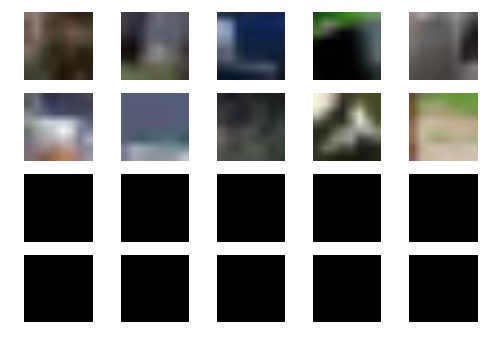

In [32]:
pred = autoencoder.forward(X)
# 出力はベクトル化されているのものを元の形に戻す
pred = pred.reshape(-1, 8, 8, 3)

plt.figure(dpi=200)
# 元画像
for i in range(10):
    plt.subplot(4,5,i+1)
    plt.imshow(X_hat[i].reshape(8, 8, 3))
    plt.axis('off')
# 復元画像
for i in range(10, 20):
    plt.subplot(4,5,i+1)
    plt.imshow(deprocess_image(pred[i-10]))
    plt.axis('off')

### 重みの可視化

最後に全結合層の重みを可視化しています。全結合層の重みはベクトル化されているので、画像として見られるようにreshapeします。中間層は今回64に設定したので、64枚の重みを見ることができます。ここではそのうちの初めの25枚を可視化しています。

**[オプション]** 関数`make_autoencoder`内のパラメータ$\beta$を0（スパース正則化なし）にした時に結果と比較して下さい。学習された重みが全く異なるはずです。

In [33]:
# 学習したオートエンコーダの1つ目の全結合層の重みを取得
W = np.copy(autoencoder.layers[0].W)
# 画像として扱えるように変換
W = W.transpose()
W = W.reshape(64, 8, 8, 3)

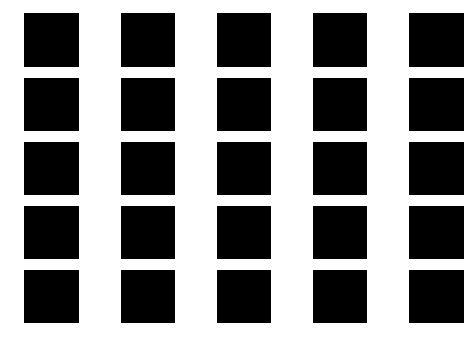

In [34]:
plt.figure(dpi=200)
for i in range(25):
    w = deprocess_image(W[i])
    plt.subplot(5,5,i+1)
    plt.imshow(w, 'gray')
    plt.axis('off')

ここで学習した重みを畳み込み層の重みとして使用することもできます。

# 【オプション】　オートエンコーダを用いたノイズ除去

オートエンコーダの活用法の１つとして、画像のノイズ除去があります。これまでは全結合層のみでオートエンコーダを構成してきましたが、ここでは畳み込み層も使ったオートエンコーダを構築します。

## ライブラリのインストール

ここでは[Keras](https://keras.io/)と呼ばれるライブラリを使います。TensorFlow V1.4からはcore TensorFlow APIとなり、現在はTensorFlowを導入するだけKerasを使うことができます。TensorFlowに入っているKerasを使う場合は

from tensorflow.python.keras.layers import Input

と書きます。（バージョンによって書き方が異なることがあります。）

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, Reshape, Conv2DTranspose, Flatten
from keras.layers import Input
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model

Using TensorFlow backend.


## データの読み込み

今回はMNISTの画像にノイズを加えて、そのノイズを取り除くことを目標とします。

ここではまず、MNISTデータ・セットを読み込み、扱いやすい形に変換します。その後、分散0.5、平均0.5のガウシアンノイズを画像に加えます。これにより、画像のピクセル値が0以下あるいは1以上になってしまうこともあるので、最後に0~1の間の値を取るようにクリッピングします。

In [36]:
# MNISTを読み込む、ラベルは不要なので"_"とする
(X_train, _), (X_test, _) = mnist.load_data()

# 画像の形を整えて、0~1の値を取るようにする
img_num, h, w= X_train.shape
X_train = np.reshape(X_train, [-1, h, w, 1])
X_test = np.reshape(X_test, [-1, h, w, 1])
X_train = X_train / 255.
X_test = X_test / 255.

# 画像に平均0.5、分散0.5のガウシアンノイズを加える
noise = np.random.normal(loc=0.5, scale=0.5, size=X_train.shape)
X_train_noisy = X_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=X_test.shape)
X_test_noisy = X_test + noise

# 画像が0~1の値を取るようにクリッピングする
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

11493376/11490434 [==============================] - 1s 0us/step


元画像とノイズを加えた画像をみてみましょう。セルを実行するたびに画像が変わります。

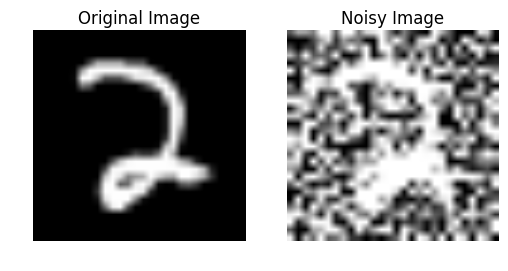

In [37]:
num = np.random.randint(0, len(X_test))

plt.subplot(1,2,1)
plt.imshow(X_test[num].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(X_test_noisy[num].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Noisy Image')

## 畳み込み層と転置畳み込み層の実装

画像を畳み込み層に渡すと出力の特徴マップは入力よりも小さくなってしまいます。そこで、転置畳み込み層を導入します。転置畳み込み層の順伝播は畳み込み層の逆伝播と同じです。図にすると以下のようになります。

<div style="width:60%">
<img src="./img/step4_deconv.png"></div>

これは２×２の入力対して、ストライド幅２，フィルタサイズ３、ゼロパディング１の転置畳み込み層を適用した結果です。これにより4×4の出力が得られます。この計算を少し説明しますと、画像上段では、入力の左上の1とフィルタを掛け合わしたものを出力の左上の値とします。次に下段では入力の-1とフィルタを掛け合わしたものを出力の右上とします。ここではストライド幅が２なので、出力画像上で２フィルタを移動させています。上段と下段で重なっている領域は単純に値を足します。

この転置畳み込み層ですが、英語ではTransposed Convlutional Layer、Deconvolution, Convolution transpose, backward strided convolution, upconvolutionなどと様々な呼び名があります。

**【確認１】**Kerasの関数を用いて、畳み込み層と転置畳み込みを実装します。

Kerasの[Conv2D](https://keras.io/layers/convolutional/#conv2d)と[Conv2DTranspose](https://keras.io/layers/convolutional/#conv2dtranspose)を用いてこれらの層を用意します。

関数`conv2d`と関数`conv2d_t`は引数として
- x: 入力画像（特徴マップ)
- filters: フィルタ数（int型)

があります。

[Conv2D](https://keras.io/layers/convolutional/#conv2d)と[Conv2DTranspose](https://keras.io/layers/convolutional/#conv2dtranspose)はともに多くの引数がありますが、今回は
- filters=filters：フィルタ数の設定
- kernel_size=３：カーネルサイズの設定、(3,3)としてもOK
- strides=2：ストライド幅の設定、(2,2)としてもOK
- padding='SAME'：パディングのオプション
- kernel_initializer='he_uniform'：[he uniform](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf)と呼ばれる方法で初期化
- activation='relu': 活性化関数

とします。これ以外にもいろいろと設定できるのでぜひドキュメントを読んで見てください。

In [38]:
def conv2d(x, filters):
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    out = Conv2D(filters=None, kernel_size=None, strides=None, 
                padding=None, kernel_initializer=None, activation=None)(None)
    ################END CODE HERE################
    return out

In [39]:
def conv2d_t(x, filters):
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    out = Conv2DTranspose(filters=None, kernel_size=None, strides=None, 
                  padding=None, kernel_initializer=None, activation=None)(None)
    ################END CODE HERE################
    return out

## モデルの実装

**【確認２】**作成した関数とKerasの関数を用いてモデルを実装します。

ここでは、ノイズ除去のためのオートエンコーダを実装します。このモデルでは、
- conv1: フィルタ数32の畳み込み層
- conv2: フィルタ数64の畳み込み層
- shape:　後で形を復元できるように形を保存
- fc1: ユニット数16の全結合層、全結合層は[Dense](https://keras.io/layers/core/#dense)を使う
- fc2: ユニット数がconv2の出力サイズ分（縦×横×チャンネ数）の全結合層
- reshape: conv2の出力と同じ形になるように変形
- conv_t1: フィルタ数64のTransposed Convolutional Layer
- conv_t2: フィルタ数32のTransposed Convolutional Layer
- outputs: フィルタ数１，カーネルサイズ３，パディング’SAME'、活性化関数シグモイドの畳み込み層

とします。Kerasの関数の使い方ですが、例えば新たにユニット数24の全結合を追加したい場合、一つ前の層の出力をoutとすると、

fc = Dense(24)(out)

と書くことができます。また先ほど作成した関数`conv2d`をフィルタ数１２で使用する場合、

conv1 = conv2d(out, 12)

と書きます。

In [40]:
input_shape = (h, w, 1)
inputs = Input(shape=input_shape)
###############START CODE HERE###############
#適切な 関数・変数・値 などにNoneを書き換えてください。
conv1 = conv2d(None, None)
conv2 = conv2d(None, None)
shape = conv2.shape.as_list()[1:] #Kerasでは自動的にミニバッチ用の次元が確保される
flat = Flatten()(None)
fc1 = Dense(None)(None)
fc2= Dense(shape[0]*shape[1]*shape[2])(None)
reshaped = Reshape(shape)(None)
conv_t1 = conv2d_t(None, None)
conv_t2 = conv2d_t(None, None)
outputs = Conv2D(filters=1, kernel_size=3, padding='SAME', activation=None)(None)
################END CODE HERE################
model = Model(inputs, outputs, name='autoencoder')

ValueError: The `kernel_size` argument must be a tuple of 2 integers. Received: None

### モデルの確認

下記のように書くことにより、モデルの全体像をみることができます。

In [ ]:
model.summary()

## モデルの学習と学習モデルの読み込み

今回は計算資源の関係で１から学習すると時間がかかってしまうので、学習済みの重みを読み込むことにします。参考までに学習時に使ったコードをコメントアウトした状態で書いておきます。

In [ ]:
# model.compile(loss='mse', optimizer='adam')
# model.fit(X_train_noisy, X_train, validation_data=(X_test_noisy, X_test), epochs=30, batch_size=256)
# model.save('weights.hdf5')
model = load_model('./dataset/step4_weights.h5')

このモデルはコスト関数を平均二乗誤差（MSE)としADAM法で30エポック学習させました。そのときのロスカーブは下図のようになりました。

<div style="width:40%">
<img src="./img/step4_autoencoder_loss_curve.png" height="200"></div>

## テスト用データで結果の確認

### テスト用データのノイズ除去

テスト用データを学習したモデルに渡します。verbose=1とすると進捗バーが表示されます。逆にverbose=0とすると何も表示されません。

In [ ]:
X_denoised = model.predict(X_test_noisy, verbose=1)

### 結果の可視化

最後にノイズ除去された画像を元の画像とノイズを加えた画像とともに比較してみます。

In [ ]:
plt.subplot(1,3,1)
num = np.random.randint(0, len(X_test))
plt.imshow(X_test[num].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(X_test_noisy[num].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Noisy Image')

plt.subplot(1,3,3)
plt.imshow(X_denoised[num].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Denoised Image')

ノイズ除去された画像は元の画像よりもぼやけた画像になってしまっているとは思いますが、ノイズはそれなりに綺麗に取り除けていると思います。